✅ Geometry generated:
- Nodes: 12
- Panels: 16


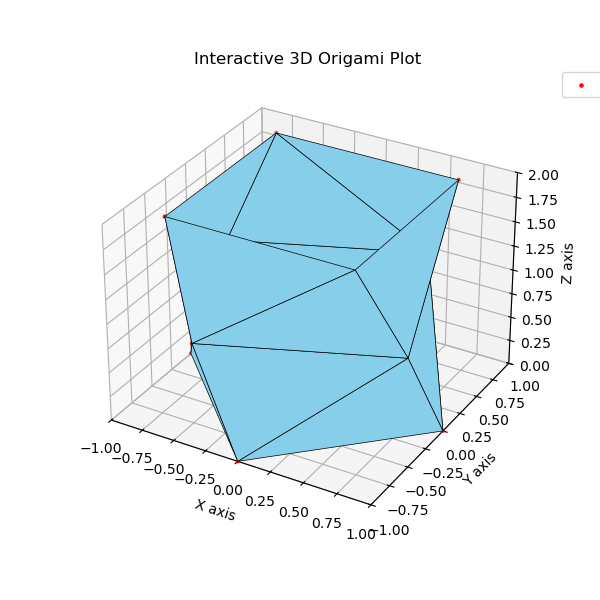

In [15]:
import numpy as np
%matplotlib widget


# === Define geometry and material parameters ===
N = 4             # Number of polygon sides
h = 1              # Height of each layer
lyr = 3           # Number of layers
phi = -np.pi / 8   # Twist angle per layer (can also be a list)

MaxIcr = 180       # Max number of increments
blam = 0.032       # Initial load factor

Kf = 1e-3          # Folding stiffness
Kb = Kf            # Bending stiffness
E0 = 5e3           # Stretching stiffness
Abar = 0.1         # Uniform cross-sectional area

limlft_deg = 45        # Linear limit left (deg)
limrht_deg = 315       # Linear limit right (deg)

# === Generate node coordinates and triangular panel connectivity ===
Node, Panel = get_di_sim(N, h, lyr, phi)

# === Print summary ===
print(f"✅ Geometry generated:\n- Nodes: {Node.shape[0]}\n- Panels: {len(Panel)}")

plot_ori(Node, Panel)

In [16]:
indsupp = np.where(Node[:, 2] < 0.01)[0]
nsupp = len(indsupp)

Supp = np.zeros((nsupp, 4), dtype=int)
Supp[0, :] = [indsupp[0], 1, 1, 1]
Supp[1, :] = [indsupp[1], 1, 1, 1]
Supp[2:, 0] = indsupp[2:]
Supp[2:, 1:] = np.array([1, 1, 1])  # equivalent to MATLAB's zeros + 1 and ones

# Define number of nodes
m = Node.shape[0]

# Find nodes at the top (max z)
indp = np.where(np.abs(Node[:, 2] - np.max(Node[:, 2])) < 1e-5)[0]
npp = len(indp)

# Define Load
Lo = 15
Load = np.column_stack((indp, np.zeros((npp, 2)), -Lo * np.ones(npp)))

In [17]:
Bend = findbend(Panel, Node)
Fold, Bdry, Trigl = findfdbd( Panel ) ;

Bars = np.vstack([
    Fold[:, :2],
    Bdry
])

i = 0 
Coord = Node 
List = Fold[i]

In [18]:
truss, angles, F = PrepareData(Node, Panel, Supp, Load, BarMater , RotSpring , Kf , Abar ) ; 

In [ ]:
import numpy as np

def FoldKe(Coord, List, kpi, h0, L0, CM):

    print(f'Coord = {Coord}')
    print(f'List = {List}')
    print(f'kpi = {kpi}')
    print(f'h0 = {h0}')
    print(f'L0 = {L0}')
    # --- Retrieve vectors (as column vectors) ---
    p0, p1, p2, p3 = Coord[List]  # List is assumed 0-indexed
    rkj = (p1 - p0).reshape(3, 1) ; 
    rij = (p2 - p0).reshape(3, 1) ; 
    rkl = (p1 - p3).reshape(3, 1) ; 

    # --- Cross products ---
    rmj = np.cross(rij.T, rkj.T).T  # shape (3, 1)
    rnk = np.cross(rkj.T, rkl.T).T  # shape (3, 1)

    # --- Angle computation ---
    dot_rnk_rij = float(rnk.T @ rij) ; 
    sgn = np.sign(dot_rnk_rij) if np.abs(dot_rnk_rij) > 1e-8 else 1

    cos_theta = float(rmj.T @ rnk) / (np.linalg.norm(rmj) * np.linalg.norm(rnk)) ; 
    cos_theta = np.clip(cos_theta, -1.0, 1.0) ; 
    he = sgn * np.arccos(cos_theta) ; 
    if he < 0:
        he += 2 * np.pi ; 

    [Rspr, Kspr] = CM(he,h0,kpi,L0) ;

    # --- Precomputations ---
    norm_rkj = np.linalg.norm(rkj) ; 
    rmj_dot = float(rmj.T @ rmj) ; 
    rnk_dot = float(rnk.T @ rnk)  ;
    rkj_dot = float(rkj.T @ rkj) ; 
    rij_dot_rkj = float(rij.T @ rkj) ; 
    rkl_dot_rkj = float(rkl.T @ rkj) ; 

    # --- Gradient vectors ---
    di = (norm_rkj / rmj_dot) * rmj ;
    dl = -(norm_rkj / rnk_dot) * rnk ; 
    dj = (rij_dot_rkj / rkj_dot - 1) * di - (rkl_dot_rkj / rkj_dot) * dl ; 
    dk = -(rij_dot_rkj / rkj_dot) * di + (rkl_dot_rkj / rkj_dot - 1) * dl ; 

    Jhe = np.vstack([dj, dk, di, dl])  ; 
    Rhe = Rspr*Jhe ;

    # --- Hessian blocks ---

    def outer_sum(a, b):
        return a @ b.T + b @ a.T

    # dii
    cr = np.cross(rkj.T, rmj.T).T ; 
    dii = -norm_rkj / rmj_dot**2 * outer_sum(rmj, cr) ; 

    # dij
    vec_ij = rij - rkj ; 
    cr_ij = np.cross(vec_ij.T, rmj.T).T ; 
    dtempij = -norm_rkj / rmj_dot**2 * outer_sum(rmj, cr_ij) ; 
    dij = -rmj @ rkj.T / (rmj_dot * norm_rkj) + dtempij ; 

    # dik
    cr_ik = np.cross(rij.T, rmj.T).T ; 
    dtempik = norm_rkj / rmj_dot**2 * outer_sum(rmj, cr_ik) ; 
    dik = rmj @ rkj.T / (rmj_dot * norm_rkj) + dtempik ; 

    # dll
    cr_ll = np.cross(rkj.T, rnk.T).T ; 
    dll = norm_rkj / rnk_dot**2 * outer_sum(rnk, cr_ll) ; 

    # dlk
    cr_lk = np.cross((rkl - rkj).T, rnk.T).T ; 
    dlk = -rnk @ rkj.T / (rnk_dot * norm_rkj) + norm_rkj / rnk_dot**2 * outer_sum(rnk, cr_lk) ; 

    # dlj
    cr_lj = np.cross(rnk.T, rkl.T).T ; 
    dlj = rnk @ rkj.T / (rnk_dot * norm_rkj) + norm_rkj / rnk_dot**2 * outer_sum(rnk, cr_lj) ; 

    # dil (zero matrix)
    dil = np.zeros((3, 3)) ; 

    # --- djj, djk, dkk ---

    dT1jj = (1 / rkj_dot) * (((-1 + 2 * rij_dot_rkj / rkj_dot) * rkj) - rij) ; 
    dT2jj = (1 / rkj_dot) * ((2 * rkl_dot_rkj / rkj_dot) * rkj - rkl) ; 
    djj = di @ dT1jj.T + (rij_dot_rkj / rkj_dot - 1) * dij - (dl @ dT2jj.T + (rkl_dot_rkj / rkj_dot) * dlj) ; 

    dT1jk = (1 / rkj_dot) * (-2 * rij_dot_rkj / rkj_dot * rkj + rij) ; 
    dT2jk = (1 / rkj_dot) * ((1 - 2 * rkl_dot_rkj / rkj_dot) * rkj + rkl) ; 
    djk = di @ dT1jk.T + (rij_dot_rkj / rkj_dot - 1) * dik - (dl @ dT2jk.T + (rkl_dot_rkj / rkj_dot) * dlk) ; 

    # dkk (same pattern with flipped terms)
    dkk = dl @ dT1jk.T + (rkl_dot_rkj / rkj_dot - 1) * dlk - (di @ dT2jk.T + (rij_dot_rkj / rkj_dot) * dik) ; 

    # --- Final 12x12 Hessian matrix ---
    Hp = np.block([
        [djj , djk , dij.T , dlj.T],
        [djk.T, dkk , dik.T , dlk.T],
        [dij , dik , dii   , dil  ],
        [dlj , dlk , dil.T , dll  ]
    ])

    Khe = Kspr * (Jhe @ Jhe.T) + Rspr * Hp ; 

    return he, Rhe, Khe

fel = 0 ; 
Lfold = truss['L'][0:angles['fold'].shape[0]] ; 
fold = angles['fold'][fel] ; 
            #def FoldKe(Coord, List, kpi, h0, L0, CM):
_, Rpe, Kpe = FoldKe(Node, fold, angles['kpf'][0] , angles['pf0'][0][fel], Lfold[fel], angles['CM']);

Coord = [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 6.12323400e-17  1.00000000e+00  0.00000000e+00]
 [-1.00000000e+00  1.22464680e-16  0.00000000e+00]
 [-1.83697020e-16 -1.00000000e+00  0.00000000e+00]
 [ 9.23879533e-01 -3.82683432e-01  1.00000000e+00]
 [ 3.82683432e-01  9.23879533e-01  1.00000000e+00]
 [-9.23879533e-01  3.82683432e-01  1.00000000e+00]
 [-3.82683432e-01 -9.23879533e-01  1.00000000e+00]
 [ 7.07106781e-01 -7.07106781e-01  2.00000000e+00]
 [ 7.07106781e-01  7.07106781e-01  2.00000000e+00]
 [-7.07106781e-01  7.07106781e-01  2.00000000e+00]
 [-7.07106781e-01 -7.07106781e-01  2.00000000e+00]]
List = [0 5 1 4]
kpi = [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
h0 = 2.563548813365402
L0 = 1.4948689358167224
he = 2.563548813365402
h0 = 2.563548813365402
kpi = [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
L0 = 1.4948

/var/folders/mv/k1gy43r50tq3vsmhxgpcdyrc0000gn/T/ipykernel_30081/3922897663.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dot_rnk_rij = float(rnk.T @ rij) ;
/var/folders/mv/k1gy43r50tq3vsmhxgpcdyrc0000gn/T/ipykernel_30081/3922897663.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cos_theta = float(rmj.T @ rnk) / (np.linalg.norm(rmj) * np.linalg.norm(rnk)) ;
/var/folders/mv/k1gy43r50tq3vsmhxgpcdyrc0000gn/T/ipykernel_30081/3922897663.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operat

In [51]:
angles['kpf'][0]

array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001])

In [50]:
_, Rpe, Kpe = FoldKe(Node, fold, angles['kpf'][0] , angles['pf0'][0][fel], Lfold[fel], angles['CM']);

Coord = [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 6.12323400e-17  1.00000000e+00  0.00000000e+00]
 [-1.00000000e+00  1.22464680e-16  0.00000000e+00]
 [-1.83697020e-16 -1.00000000e+00  0.00000000e+00]
 [ 9.23879533e-01 -3.82683432e-01  1.00000000e+00]
 [ 3.82683432e-01  9.23879533e-01  1.00000000e+00]
 [-9.23879533e-01  3.82683432e-01  1.00000000e+00]
 [-3.82683432e-01 -9.23879533e-01  1.00000000e+00]
 [ 7.07106781e-01 -7.07106781e-01  2.00000000e+00]
 [ 7.07106781e-01  7.07106781e-01  2.00000000e+00]
 [-7.07106781e-01  7.07106781e-01  2.00000000e+00]
 [-7.07106781e-01 -7.07106781e-01  2.00000000e+00]]
List = [0 5 1 4]
kpi = [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
h0 = 2.563548813365402
L0 = 1.4948689358167224


/var/folders/mv/k1gy43r50tq3vsmhxgpcdyrc0000gn/T/ipykernel_30081/3922897663.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dot_rnk_rij = float(rnk.T @ rij) ;
/var/folders/mv/k1gy43r50tq3vsmhxgpcdyrc0000gn/T/ipykernel_30081/3922897663.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cos_theta = float(rmj.T @ rnk) / (np.linalg.norm(rmj) * np.linalg.norm(rnk)) ;
/var/folders/mv/k1gy43r50tq3vsmhxgpcdyrc0000gn/T/ipykernel_30081/3922897663.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operat

In [45]:
print( Rpe )

[[-0.]
 [-0.]
 [-0.]
 [-0.]
 [-0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]
 [ 0.]
 [ 0.]]


In [47]:
angles['pf0'][0][fel]

np.float64(2.563548813365402)

In [49]:
from scipy.sparse import coo_matrix
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from scipy.sparse import coo_matrix, lil_matrix
import numpy as np

import numpy as np

def icross(a, b):
    c = np.array([
        a[1] * b[2] - a[2] * b[1],
        a[2] * b[0] - a[0] * b[2],
        a[0] * b[1] - a[1] * b[0]
    ])
    return c

def FoldKe_prepareData(Coord, List):


    rkj = np.transpose( Coord[List[1]] - Coord[List[0]] )
    rij = np.transpose( Coord[List[2]] - Coord[List[0]] )
    rkl = np.transpose( Coord[List[1]] - Coord[List[3]] )

    rmj = icross(rij,rkj); rnk = icross(rkj,rkl);

    dot_rnk_rij = np.dot(rnk, rij)
    sgn = np.sign(dot_rnk_rij) if abs(dot_rnk_rij) > 1e-8 else 1

    cos_theta = np.dot(rmj, rnk) / (np.linalg.norm(rmj) * np.linalg.norm(rnk))
    # Clamp to avoid domain error in case of numerical imprecision
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    he = float(sgn) * np.arccos(cos_theta)

    if he < 0:
        he = 2 * np.pi + he ;
    
    return he 


def findbend(panel, node):
    bend = []
    for p in panel:
        if len(p) == 4:
            L1 = np.linalg.norm(node[p[0] - 1] - node[p[2] - 1])
            L2 = np.linalg.norm(node[p[3] - 1] - node[p[1] - 1])
            if L1 > L2:
                lclbend = [p[1], p[3], p[0], p[2]]
            else:
                lclbend = [p[0], p[2], p[1], p[3]]
            bend.append(lclbend)
    return np.array(bend)

def findfdbd(Panel):
    Nn = max(max(p) for p in Panel)
    panelsize = [len(p) for p in Panel]

    Ptri = [Panel[i] for i in range(len(Panel)) if panelsize[i] == 3]

    Triglraw = np.vstack([
        np.array(Ptri)
    ])

    Trigl = np.unique(np.sort(Triglraw, axis=1), axis=0)

    # Assume Trigl is already defined as a (n_triangles, 3) ndarray
    Nn = np.max(Trigl) + 1  # number of nodes

    # --- Build Comm matrix (shape: Nn x n_triangles) ---
    row_idx = []
    col_idx = []
    data = []

    for i in range(Trigl.shape[0]):
        for node in Trigl[i]:
            row_idx.append(node)
            col_idx.append(i)
            data.append(1)

    Comm = coo_matrix((data, (row_idx, col_idx)), shape=(Nn, Trigl.shape[0]), dtype=int)

    # --- Compute Ge = Comm.T @ Comm ---
    Ge = (Comm.transpose().dot(Comm)).tocoo()

    # --- Find pairs of triangles that share 2 nodes ---
    Ge_dense = Ge.toarray()
    mf, me = np.where(np.triu(Ge_dense == 2))  # upper triangular part only

    # --- Build fold array ---
    fold = np.zeros((len(mf), 4), dtype=int)

    for i in range(len(mf)):
        t1 = Trigl[mf[i]]
        t2 = Trigl[me[i]]
        
        # Find shared nodes and their indices
        link, ia, ib = np.intersect1d(t1, t2, return_indices=True)
        
        oftpa = [j for j in range(3) if j not in ia]
        oftpb = [j for j in range(3) if j not in ib]

        fold[i, :] = np.concatenate([link, [t1[oftpa[0]], t2[oftpb[0]]]])

    Fold = fold[np.argsort(fold[:, 0])]

    Edge = np.sort(
        np.vstack([
            Trigl[:, [0, 1]],
            Trigl[:, [1, 2]],
            Trigl[:, [2, 0]]
        ]), axis=1
    )

    u, inv, count = np.unique(Edge, axis=0, return_inverse=True, return_counts=True)
    bdry = u[count == 1]

    return Fold, bdry, Trigl

def plot_ori(Node, Panel, color='skyblue', alpha=1.0):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot nodes
    ax.scatter(Node[:, 0], Node[:, 1], Node[:, 2], c='red', s=5, label='Nodes')

    # Plot panels
    faces = [Node[np.array(p)] for p in Panel]  # Already zero-based indexing
    poly = Poly3DCollection(faces, facecolors=color, edgecolors='k', linewidths=0.5)
    poly.set_alpha(alpha)
    ax.add_collection3d(poly)

    # Axes labels and title
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Z axis")
    ax.set_title("Interactive 3D Origami Plot")
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0), borderaxespad=0.)

    # Equal aspect ratio
    max_range = (Node.max(axis=0) - Node.min(axis=0)).max()
    mid = (Node.max(axis=0) + Node.min(axis=0)) / 2
    ax.set_xlim(mid[0] - max_range/2, mid[0] + max_range/2)
    ax.set_ylim(mid[1] - max_range/2, mid[1] + max_range/2)
    ax.set_zlim(mid[2] - max_range/2, mid[2] + max_range/2)

    # Optional: turn axis on or off
    # ax.axis('off')

    plt.show()

def get_di_sim(N,h,lyr,phi):

    if np.isscalar(phi):
        rotangle = np.arange(lyr) * phi
    else:
        rotangle = np.array(phi)

    # Compute angular positions for each layer
    rdl = np.zeros((lyr, N))
    for i in range(lyr):
        rdl[i, :] = np.linspace(rotangle[i], 2 * np.pi / N * (N - 1) + rotangle[i], N)

    # Flatten node coordinates correctly for any lyr
    Xcood = np.cos(rdl).reshape(-1)
    Ycood = np.sin(rdl).reshape(-1)
    Zcood = np.repeat(np.arange(lyr), N) * h

    Node = np.column_stack((Xcood, Ycood, Zcood))

    # Build triangular panels
    Panel = []
    for i in range(lyr - 1):
        offset = i * N
        for j in range(N):
            a = offset + j
            b = offset + j + N
            c1 = offset + (j + 1) % N + N
            c2 = offset + (j + 1) % N

            Panel.append([a, b, c1])
            Panel.append([a, c2, c1])

    return Node, Panel
    
def dirc3d(Node, Ele):


    Ne = Ele.shape[0]
    Nn = Node.shape[0]

    # Compute direction vectors and normalize
    D = Node[Ele[:, 1], :] - Node[Ele[:, 0], :]
    L = np.linalg.norm(D, axis=1)
    D_unit = D / L[:, np.newaxis]

    # Assemble sparse matrix
    row = np.repeat(np.arange(Ne), 6)
    col = np.hstack([
        3 * Bars[:, 0] + 0,
        3 * Bars[:, 0] + 1,
        3 * Bars[:, 0] + 2,
        3 * Bars[:, 1] + 0,
        3 * Bars[:, 1] + 1,
        3 * Bars[:, 1] + 2
    ]).reshape(Ne, 6).flatten()

    data = np.hstack([D_unit, -D_unit]).flatten()

    B = coo_matrix((data, (row, col)), shape=(Ne, 3 * Nn)).tocsc()
    B = -B
    
    return B, L

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.sparse import coo_matrix

def PrepareData(Node, Panel, Supp, Load, BarCM, RotSpring, kpf, Abar):

    # Bend = findbend(Panel, Node);

    # Find folds and boundaries
    Fold, Bdry, Trigl = findfdbd(Panel)
    
    # Combine bars from folds and boundaries
    Bars = np.vstack((Fold[:, :2], Bdry))
    
    # Compute bar directions and lengths
    B, L = dirc3d(Node, Bars)

    if Supp.shape[0] == 0:
        rs = np.array([], dtype=int)
    else:
        # Generate the first column (flattened index mapping)
        idx = np.vstack((Supp[:, 0]*3-2 , Supp[:, 0]*3-1 , Supp[:, 0]*3)).T.flatten()
        val = Supp[:, 1:4].T.flatten()

        rs = np.vstack((idx, val)).T

        # Remove rows where the second column is zero
        rs = rs[rs[:, 1] != 0]
        rs = rs[:, 0]  # Only keep the index values
        rs += 2 

    # Expand Abar if it's a scalar
    if np.isscalar(Abar):
        Abar = Abar * np.ones((Bars.shape[0], 1))
    
    # Compute initial fold angles
    pf0 = np.zeros((Fold.shape[0],))
    for i in range(Fold.shape[0]):
        pf0[i] = FoldKe_prepareData(Node, Fold[i,:])
    
    m = Node.shape[0]
    F = np.zeros((3 * m,))
    indp = Load[:, 0].astype(int)
    F[3 * indp] = Load[:, 1]
    F[3 * indp+1] = Load[:, 2]
    F[3 * indp+2] = Load[:, 3]

    # Build result structures
    truss = {
        "CM": BarCM,
        "Node": Node,
        "Bars": Bars,
        "Trigl": Trigl,
        "B": B,
        "L": L,
        "FixedDofs": np.unique(rs),
        "A": Abar
    }

    angles = {
        "CM": RotSpring,
        "fold": Fold,
        "kpf": kpf * np.ones((1, Fold.shape[0])),
        "pf0": pf0.reshape(1, -1),
        "Panel": Panel
    }

    return truss, angles, F


def BarMater(Ex):
    return Ogden_2(Ex, 5000.0)

def RotSpring(he, h0, kpi, L0):
    return EnhancedLinear_TwoOut(he, h0, kpi, L0, limlft, limrht)

def Ogden_2(Ex, C0):
    alpha = [5, 1]
    pstr = np.real(np.sqrt(2 * Ex + 1))

    # C0 scaling is kept as-is (effectively no change)
    Et = C0 / (alpha[0] - alpha[1]) * ((alpha[0] - 2) * pstr**(alpha[0] - 4) - (alpha[1] - 2) * pstr**(alpha[1] - 4))
    Sx = C0 / (alpha[0] - alpha[1]) * (pstr**(alpha[0] - 2) - pstr**(alpha[1] - 2))
        
    return Sx, Et

def EnhancedLinear_TwoOut(he,h0,kpi,L0,limlft_deg,limrht_deg):

    # print(f'he = {he}')
    # print(f'h0 = {h0}')
    # print(f'kpi = {kpi}')
    # print(f'L0 = {L0}')

    limlft = np.radians(limlft_deg)
    limrht = np.radians(limrht_deg)

    partl = np.pi / limlft
    partr = np.pi / (2 * np.pi - limrht)

    if he < limlft:
        Rspr = kpi[0] * (limlft - h0) + kpi[0] * np.tan(partl / 2 * (he - limlft)) / (partl / 2)
        Kspr = kpi[0] * (1 / np.cos(partl / 2 * (he - limlft)))**2
    elif he > limrht:
        Rspr = kpi[0] * (limrht - h0) + kpi[0] * np.tan(partr / 2 * (he - limrht)) / (partr / 2)
        Kspr = kpi[0] * (1 / np.cos(partr / 2 * (he - limrht)))**2
    else:
        Rspr = kpi[0] * (he - h0)
        Kspr = kpi[0]

    Rspr *= L0
    Kspr *= L0

    return Rspr, Kspr 
